# AutoEncoder on Gene Expression

In [6]:
# utils
%load_ext autoreload
%autoreload 1

import sys
sys.path.append("../utils/")
%aimport utils

# keras
from keras import backend as K
from keras.models import Model, Input
from keras.layers import Dense
from keras.regularizers import l1, l2
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

n_cores = 10

K.set_session(K.tf.Session(config=K.tf.ConfigProto(
    intra_op_parallelism_threads=n_cores, 
    inter_op_parallelism_threads=n_cores)))

# math
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading of the data

In [2]:
X_path = "./data/KIRC_gene_exp.tsv"
X_meta_path = "./data/KIRC_clinicalMatrix.tsv"

In [3]:
X, y, \
idx_to_patient, patient_to_idx, \
idx_to_gene, gene_to_idx = utils.load_stage_data(X_path, X_meta_path)

# patients with Primary Tumor and Stage I, Stage II, Stage III, Stage IV: 531


### Loading all TCGA dataset

In [4]:
tcga, c_names = utils.get_all_tcga()

Cancer: HNSC
	#samples: 566
	#genes: 20530
	#TUMORS: 522	#NORMAL: 44
Cancer: GBM
	#samples: 172
	#genes: 20530
	#TUMORS: 167	#NORMAL: 5
Cancer: KIRC
	#samples: 606
	#genes: 20530
	#TUMORS: 534	#NORMAL: 72
Cancer: LIHC
	#samples: 423
	#genes: 20530
	#TUMORS: 373	#NORMAL: 50
Cancer: KIRP
	#samples: 323
	#genes: 20530
	#TUMORS: 291	#NORMAL: 32
Cancer: PRAD
	#samples: 550
	#genes: 20530
	#TUMORS: 498	#NORMAL: 52
Cancer: ESCA
	#samples: 196
	#genes: 20530
	#TUMORS: 185	#NORMAL: 11
Cancer: COAD
	#samples: 329
	#genes: 20530
	#TUMORS: 288	#NORMAL: 41
Cancer: CHOL
	#samples: 45
	#genes: 20530
	#TUMORS: 36	#NORMAL: 9
Cancer: UCEC
	#samples: 201
	#genes: 20530
	#TUMORS: 177	#NORMAL: 24
Cancer: LUSC
	#samples: 553
	#genes: 20530
	#TUMORS: 502	#NORMAL: 51
Cancer: LGG
	#samples: 530
	#genes: 20530
	#TUMORS: 530	#NORMAL: 0
Cancer: UVM
	#samples: 80
	#genes: 20530
	#TUMORS: 80	#NORMAL: 0
Cancer: THCA
	#samples: 572
	#genes: 20530
	#TUMORS: 513	#NORMAL: 59
Cancer: KICH
	#samples: 91
	#genes: 20530
	#T

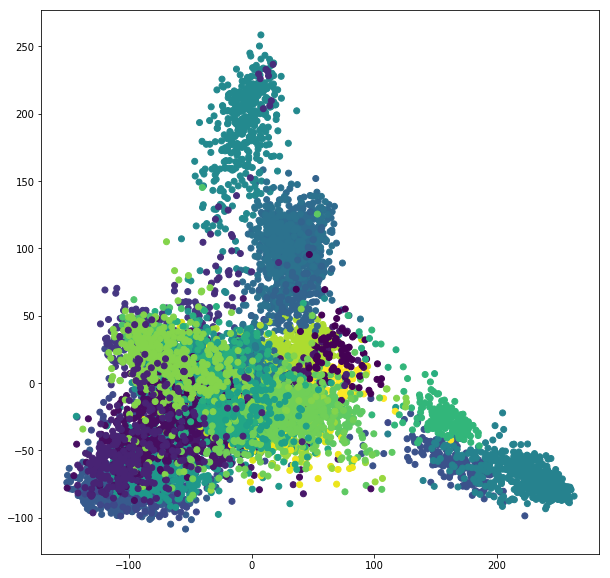

In [7]:
plt.figure(figsize=(10, 10))
utils.plot_PCA(tcga, c_names)
plt.show()

### Pre-processing

In [ ]:
def filter_genes(X, top_k=5000):
    stds = X.std(0) # 1 x n.genes
    selected_genes = np.argsort(stds)[::-1][:top_k]
    return X[:, selected_genes], selected_genes

def pre_process(X, top_k=5000):
    X_t, selected_genes = filter_genes(X, top_k)
    scaler = MinMaxScaler()
    scaler.fit(X_t)
    X_t = scaler.transform(X_t)
    return X_t, selected_genes

In [ ]:
tcga_t, top_variant_genes_idxs = filter_genes(tcga)
tcga_t.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(tcga_t)
tcga_t = scaler.transform(tcga_t)

## AutoEncoder definition

In [ ]:
def visualize_model(model):
    return SVG(model_to_dot(model, 
                            show_shapes=True, 
                            show_layer_names=True).create(prog='dot', format='svg'))

def create_sparse_autoencoder(input_shape, encoding_dim=100):
    
    encoder_input = Input(shape=(input_shape,), name="encoder_input")
    e1 = Dense(1000, activation="relu", name="embedding_layer_1")(encoder_input)
    embedding = Dense(encoding_dim,
                      activation="relu", name="embedding_layer_2")(e1)
    d1 = Dense(1000, activation="relu", name="decoding_layer_1")(embedding)
    decoder_h = Dense(input_shape, activation="sigmoid", name="decoding_layer_2")
    decoded = decoder_h(d1)
    autoencoder = Model(inputs=encoder_input, outputs=decoded, name="autoencoder")
    
    encoder = Model(inputs=encoder_input, outputs=embedding)
#     decoder_input = Input(shape=(encoding_dim, ), name="decoder_input")
#     decoder = Model(inputs=decoder_input, outputs=decoder_h(decoder_input))
    
    # compilation
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return encoder, autoencoder

In [ ]:
encoder, autoencoder = create_sparse_autoencoder(input_shape=X.shape[1], encoding_dim=10)

In [ ]:
visualize_model(autoencoder)

In [ ]:
epochs = 20
batch_size = 20
validation_split = 0.2

autoencoder.fit(tcga_t, tcga_t, verbose=0,
                shuffle=True,
                epochs=epochs,
                validation_split=validation_split,
                callbacks=[utils.get_tensorboard_callback(session_name="SAE_TCGA")])